# 2025 CITS4012 Project
*Make sure you change the file name with your group id.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pprint

# For data processing
import re
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize, sent_tokenize

# For implementing the word2vec family of algorithms
from gensim.models import FastText, KeyedVectors
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Josh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

# 1.Dataset Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## 1.1. Basic preparation: create desired format of words

In [2]:
# Load datasets
train_raw = json.load(open('train.json'))
val_raw = json.load(open('validation.json'))
test_raw = json.load(open('test.json'))

In [31]:
# Common English contractions.
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

# Preprocess a list of sentences
def pre_process(sent_list):
    output = []
    for sent in sent_list:
        sent = sent.lower() #case-folding
        for word, new_word in contraction_dict.items():
            sent = sent.replace(word, new_word) #dealing with contractions
        sent = re.sub(r'[^\w\s]','',sent) #removing punctuation
        output.append(word_tokenize(sent)) #tokenization
    return output

def pre_process_datasets(dataset):
    raw_premises = []
    raw_hypotheses = []
    labels = []
    label_keys = []
    keys_as_integers = []
    for key, value in dataset['label'].items():
        labels.append(value)
        label_keys.append(key)
        keys_as_integers.append(int(key))
    raw_premises = [dataset['premise'][key] for key in label_keys]
    raw_hypotheses = [dataset['hypothesis'][key] for key in label_keys]
    processed_premises = pre_process(raw_premises)
    processed_hypotheses = pre_process(raw_hypotheses)
    return processed_premises, processed_hypotheses, labels, keys_as_integers
        
        
# Preprocessing the training using the functions defined above
all_train_premises, all_train_hypotheses, all_train_labels, all_train_keyints = pre_process_datasets(train_raw)

# setup vocab to index dictionary
word_to_ix = {"<PAD>": 0, "<OOV>": 1}
for sentence in all_train_premises+all_train_hypotheses:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
word_list = list(word_to_ix.keys())

In [54]:
# Convert tokenized sentences to index lists
def to_index(data, to_ix, padlength=None):
    input_index_list = []
    for sent in data:
        input_index_list.append([to_ix[w] if w in to_ix else to_ix["<OOV>"] for w in sent])
    if padlength is not None:
        for i in range(len(input_index_list)):
            if len(input_index_list[i]) < padlength:
                input_index_list[i] = input_index_list[i] + [to_ix["<PAD>"]] * (padlength - len(input_index_list[i]))
    return input_index_list

def make_idx_data(data_raw, padlength=None):
    premises, hypotheses, labels, keyints = pre_process_datasets(data_raw)
    premises_idx = to_index(premises, word_to_ix, padlength)
    hypotheses_idx = to_index(hypotheses, word_to_ix, padlength)
    binary_labels = np.array([1 if label == 'entails' else 0 for label in labels])
    return premises_idx, hypotheses_idx, binary_labels, keyints

all_train_premises_idx, all_train_hypotheses_idx, all_y_train, _ = make_idx_data(train_raw)

In [55]:
# Example processing
i = '100'
print("\n ***Before Processing***")
print(train_raw['premise'][i])
print(train_raw['hypothesis'][i])
print(train_raw['label'][i])
print("\n ***After Processing***")
print(all_train_premises[int(i)])
print(all_train_hypotheses[int(i)])
print(all_train_labels[int(i)])
print("\n ***After Indexation***")
print(all_train_premises_idx[int(i)])
print(all_train_hypotheses_idx[int(i)])
print(all_y_train[int(i)])


 ***Before Processing***
By combining an up-to-date child I.D. card and the DNA I.D. Kit, parents can have a valuable child identification system.
Children resemble their parents because they have similar dna.
neutral

 ***After Processing***
['by', 'combining', 'an', 'uptodate', 'child', 'id', 'card', 'and', 'the', 'dna', 'id', 'kit', 'parents', 'can', 'have', 'a', 'valuable', 'child', 'identification', 'system']
['children', 'resemble', 'their', 'parents', 'because', 'they', 'have', 'similar', 'dna']
neutral

 ***After Indexation***
[39, 750, 285, 751, 425, 752, 753, 41, 15, 416, 752, 754, 420, 28, 67, 35, 755, 425, 756, 74]
[99, 1078, 271, 420, 1138, 97, 67, 473, 416]
0


## 1.2. Clean dataset: remove pathalogical instances

Maximum sentence length: 10563
Minimum sentence length: 0


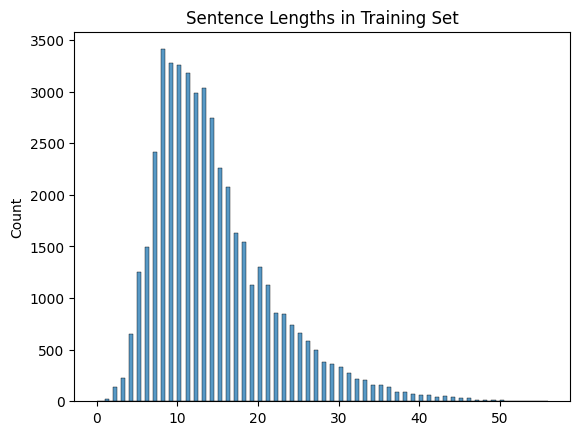

In [56]:
# create combined premise/hypothesis list from the training set to examine
all_train_sentences = all_train_premises + all_train_hypotheses

lengths = np.array([len(sent) for sent in all_train_sentences])
print(f'Maximum sentence length: {lengths.max()}')
print(f'Minimum sentence length: {lengths.min()}')

sns.histplot(lengths[lengths < 60])
plt.title('Sentence Lengths in Training Set')
plt.show()

In [72]:
# Make the final datasets, only allowing sentences up to maxlength long and padding to this maxlength
maxlength = 60

def make_final_datasets(train_raw, maxlength=maxlength):
    premises, hypotheses, labels, keys = make_idx_data(train_raw, padlength=maxlength)
    cleaned_premises = []
    cleaned_hypotheses = []
    cleaned_labels = []
    cleaned_keys = []
    for i in keys:
        if len(premises[i]) >= 3 and len(premises[i]) <= maxlength and len(hypotheses[i]) >= 3 and len(hypotheses[i]) <= maxlength:
            cleaned_premises.append(premises[i])
            cleaned_hypotheses.append(hypotheses[i])
            cleaned_labels.append(labels[i])
            cleaned_keys.append(i)
    return np.array(cleaned_premises, dtype=np.int64), np.array(cleaned_hypotheses, dtype=np.int64), np.array(cleaned_labels, dtype=np.int64), cleaned_keys


train_premises, train_hypotheses, y_train, clean_train_keyints = make_final_datasets(train_raw)
val_premises, val_hypotheses, y_val, clean_val_keyints = make_final_datasets(val_raw)
test_premises, test_hypotheses, y_test, clean_test_keyints = make_final_datasets(test_raw)

# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [63]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, dec_dim, enc_dim, attn_dim=None):
        super().__init__()
        if attn_dim is None:
            attn_dim = dec_dim
        # input to attention = [dec_hidden (dec_dim) ; enc_output (enc_dim)]
        self.attn = nn.Linear(dec_dim + enc_dim, attn_dim)
        self.v = nn.Linear(attn_dim, 1, bias=False)

    def forward(self, decoder_hidden, encoder_outputs):
        """
        decoder_hidden: [batch, dec_dim]
        encoder_outputs: [batch, src_len, enc_dim]
        """
        B, T, E = encoder_outputs.size()          # enc_dim = E
        # repeat decoder hidden across time
        hidden_rep = decoder_hidden.unsqueeze(1).expand(B, T, decoder_hidden.size(1))  # [B, T, dec_dim]
        energy = torch.tanh(self.attn(torch.cat([hidden_rep, encoder_outputs], dim=2)))  # [B, T, attn_dim]
        scores = self.v(energy).squeeze(2)        # [B, T]
        alpha = F.softmax(scores, dim=1)          # [B, T]
        return alpha

class NLIModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Encoder: bidirectional. Output dim = 2H
        self.encoder = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)

        # Decoder: unidirectional. Hidden dim = H
        self.decoder = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

        # Attention over encoder (enc_dim=2H) using decoder state (dec_dim=H)
        self.attention = Attention(dec_dim=hidden_dim, enc_dim=hidden_dim * 2, attn_dim=hidden_dim)

        # Final classifier gets [dec_hidden (H) ; context (2H)] = 3H
        self.fc = nn.Linear(hidden_dim * 3, num_classes)

    def forward(self, premise, hypothesis):
        # Encode premise
        prem_emb = self.embedding(premise)                      # [B, T_p, E]
        enc_outs, _ = self.encoder(prem_emb)                    # [B, T_p, 2H]

        # Decode hypothesis (we just use final hidden for classification)
        hypo_emb = self.embedding(hypothesis)                   # [B, T_h, E]
        dec_outs, (h, c) = self.decoder(hypo_emb)               # h: [1, B, H]
        dec_hidden = h[-1]                                      # [B, H]

        # Attention over encoder outputs using decoder final state
        attn_w = self.attention(dec_hidden, enc_outs)           # [B, T_p]
        context = torch.bmm(attn_w.unsqueeze(1), enc_outs).squeeze(1)  # [B, 2H]

        # Concatenate decoder hidden and context
        combined = torch.cat([dec_hidden, context], dim=1)      # [B, 3H]

        logits = self.fc(combined)                              # [B, num_classes]
        return F.log_softmax(logits, dim=1)

In [82]:
# Convert numpy arrays to torch tensors
train_premises   = torch.tensor(train_premises, dtype=torch.long)
train_hypotheses = torch.tensor(train_hypotheses, dtype=torch.long)
y_train          = torch.tensor(y_train, dtype=torch.long)

val_premises     = torch.tensor(val_premises, dtype=torch.long)
val_hypotheses   = torch.tensor(val_hypotheses, dtype=torch.long)
y_val            = torch.tensor(y_val, dtype=torch.long)

# Create datasets
train_ds = TensorDataset(train_premises, train_hypotheses, y_train)
val_ds   = TensorDataset(val_premises, val_hypotheses, y_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

C:\Users\Josh\AppData\Local\Temp\ipykernel_11692\2120145448.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_premises   = torch.tensor(train_premises, dtype=torch.long)
C:\Users\Josh\AppData\Local\Temp\ipykernel_11692\2120145448.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_hypotheses = torch.tensor(train_hypotheses, dtype=torch.long)
C:\Users\Josh\AppData\Local\Temp\ipykernel_11692\2120145448.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train          = torch.tensor(y_train, dtype=torch.long)
C:\Users\Josh\A

In [88]:
# ==== Model, loss, optimizer ====
vocab_size = len(word_to_ix)
embed_dim = 100
hidden_dim = 128
num_classes = 2

model = NLIModel(vocab_size, embed_dim, hidden_dim, num_classes)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==== Training & Evaluation Loop ====
def accuracy(preds, labels):
    return (preds.argmax(dim=1) == labels).float().mean().item()

for epoch in range(5):  # small number of epochs for demo
    model.train()
    train_loss, train_acc = 0, 0
    for premise, hypo, labels in train_loader:
        optimizer.zero_grad()
        output = model(premise, hypo)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy(output, labels)

    # Validation
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for premise, hypo, labels in val_loader:
            output = model(premise, hypo)
            loss = criterion(output, labels)
            val_loss += loss.item()
            val_acc += accuracy(output, labels)

    # Average across batches
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss:.3f}, Train Acc={train_acc:.3f}, "
          f"Val Loss={val_loss:.3f}, Val Acc={val_acc:.3f}")

Epoch 1: Train Loss=0.553, Train Acc=0.714, Val Loss=0.573, Val Acc=0.687
Epoch 2: Train Loss=0.416, Train Acc=0.809, Val Loss=0.581, Val Acc=0.708
Epoch 3: Train Loss=0.305, Train Acc=0.869, Val Loss=0.626, Val Acc=0.713
Epoch 4: Train Loss=0.193, Train Acc=0.924, Val Loss=0.757, Val Acc=0.708
Epoch 5: Train Loss=0.108, Train Acc=0.962, Val Loss=1.086, Val Acc=0.692


# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*